In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!python -m spacy download el_core_news_lg
import spacy as sp#tokeniser, parser tagger for greek language
import sklearn as sk
import re
import unicodedata #character properties for all Unicode characters
import nltk
from nltk.corpus import stopwords
#import demoji #translate emojis into words
#demoji.download_codes()
!pip install greek-stemmer-pos
from greek_stemmer import stemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.6/568.6 MB 2.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_lg')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 15.4 MB/s eta 0:00:00
/kaggle/input/ys19-2023-assignment-1/sample_submission.csv
/kaggle/input/ys19-2023-assignment-1/test_set.csv
/kaggle/input/ys19-2023-assignment-1/valid_set.csv
/kaggle/input/ys19-2023-assignment-1/train_set.csv
/kaggle/input/json-files/lem.json
/kaggle/input/json-files/lemstem.json
/kaggle/input/json-files/stem.json
/kaggle/input/greek-stop/Greek-Stopwords.txt


Getting Data

In [2]:
path = '/kaggle/input/ys19-2023-assignment-1/test_set.csv'
jsonpath1 = 'lem.json'
jsonpath2 = 'stem.json'
#jsonpath1 = '/kaggle/input/json-files/lem.json'
#jsonpath2 = '/kaggle/input/json-files/stem.json'
test_set = pd.read_csv(path) 
path = '/kaggle/input/ys19-2023-assignment-1/valid_set.csv'
valid_set = pd.read_csv(path) #4 columns id, text, sentiment, party
path = '/kaggle/input/ys19-2023-assignment-1/train_set.csv'
train_set = pd.read_csv(path)
#Making sure dataset is balanced
counts = train_set['Sentiment'].value_counts()
print(counts)

Sentiment
NEUTRAL     12210
NEGATIVE    12210
POSITIVE    12210
Name: count, dtype: int64


Pre-Processing of Data


Note:Spacy library does not provide a stemming utility. Therefore, greek_stemmer
was used to acquire a stem for each word. Our stemmer function matches a tag provided by the spacy library to a rough equivalent to be passed to greek_stemmer. Note that exact matching of tags is not possible due to the structural differences between the spacy tagging system and the ellogon tagging system used by greek_stemmer (which is better suited to the particularities of the greek language). 
For example spacy does not differenciate between femimin and masculin nouns, or singular and plural form. 

In [3]:
#Data Pre-Processing
nlp = sp.load("el_core_news_lg")

#Load stop words
def stopwords_list():
    with open('/kaggle/input/greek-stop/Greek-Stopwords.txt') as f:
        # return the split results, which is all the words in the file.
        return f.read().split()
    
#Remove Stop Words Function
def rem_stopwords(text):
    stop_words = stopwords_list()
    for word in stop_words: 
         word = word.replace('\n', '')
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)



#Lemmatisation
def lemmatisation(text):
    doc = nlp(text)
    ret = []
    for token in doc:
        ret.append(token.lemma_)
    return ' '.join(ret)


#Stemming
#transform spacy tagging to ellogon to apply greek stemmer
spacytoellogon = {
    "ADJ": "JJM",
    "ADP": "INP",
    "ADV": "RB",
    "AUX": "VB", #auxiliaries are verbs in greek
    "CONJ": "NNPSN",
    "CCONJ": "NNPSN",
    "DET": "DDT", #and IDT
    "INTJ": "NNPSN",
    "NOUN": "NNM",
    "NUM": "NNPSN",
    "PART": "NNPSN", #recognise ΄δεν' as an uncountable nouns
    "PRON": "PRP",
    "PROPN": "NNPSN", #recognise names as uncountable nouns
    "PUNCT": "SPACE",
    "SCONJ": "NNPSN",
    "SYM": "SPACE",
    "VERB": "VB",
    "X": "NNPSN",
    "SPACE": "SPACE" #we will ignore this in stemming 
    
}



def stemming(text):
    ret = []
    doc = nlp(text)
    for token in doc:
        if str(spacytoellogon[token.tag_]) == "SPACE":
            ret.append(' ')
        else:
            ret.append(stemmer.stem_word(str(token),str(spacytoellogon[token.tag_])))
    textlower = ' '.join(ret)
    textlower = textlower.lower()
    return textlower


#Clean training data 
train_set['Text'] = train_set['Text'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes
train_set['Text'] = [r.lower() for r in train_set['Text'] ]   #making everything lowercase
train_set['Text'] = [''.join([c for c in unicodedata.normalize('NFD', r) if not unicodedata.combining(c)]) for r in train_set['Text']] #removing accents
train_set['Text'] = train_set['Text'].apply(lambda r: re.sub(r'@\w+', '', r)) #remove mentions
train_set['Text'] = train_set['Text'].apply(lambda r: re.sub(r'([^α-ωΑ-Ω\s-])', ' ', r)) #only keeping greek letters, URLs are also removed this way
train_set['Text'] = train_set['Text'].apply(rem_stopwords) #remove stopwords




In [4]:
#Choose between lemmatisaiton and stemming 
lemmed = train_set.copy(deep=True)
stemmed = train_set.copy(deep=True)

lemmed['Text'] = lemmed['Text'].apply(lemmatisation)
stemmed['Text'] = stemmed['Text'].apply(stemming)

lemmed.to_json(jsonpath1)  #saving processed data as to not repeat this time consuming step
stemmed.to_json(jsonpath2)


Vectorisation of the data

df = pd.read_json(jsonpath3)  #loading processed data
df.head()

In [5]:
#Loading Lemmatised Data 

df = pd.read_json(jsonpath1)  #loading processed data 
df['Sentiment_Num'] = df.Sentiment.map({
    'POSITIVE':0,
    'NEUTRAL':1,
    'NEGATIVE':2
    
})
Y = list(df['Sentiment_Num'])
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=1, norm='l1')
X = vectorizer.fit_transform(df['Text'])


Macro F1 score was chosen as an suitable evaluation metric, as our data set is class balanced.

In [6]:
# Testing logistic regression tolerance on lemmatised and stemmed data

for t in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]:
    model = LogisticRegression(tol=t, C=1.0, random_state=420, max_iter=500, multi_class='multinomial', n_jobs=-1)
    scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1, scoring='f1_macro')
    print(f"for tollerance = {t}")
    print(scores.mean())

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


for tollerance = 0.1
0.37977633799496335
for tollerance = 0.01
0.37979894711570006
for tollerance = 0.001
0.37979894711570006
for tollerance = 0.0001
0.37979894711570006
for tollerance = 1e-05
0.37979894711570006
for tollerance = 1e-06
0.37979894711570006
for tollerance = 1e-07
0.37979894711570006
for tollerance = 1e-08
0.37979894711570006
for tollerance = 1e-09
0.37979894711570006


No effect after tollerance = 0.01, we will proceed with 0.01
mean f1_score = 0.3798827101953515


In [7]:
# Testing inverse regularisation strength on lemmatised data 

for c in [x * 0.1 for x in range(80, 100, 4)]:
    model = LogisticRegression(C=c, random_state=420, max_iter=500, multi_class='multinomial', n_jobs=-1)
    scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1, scoring='f1_macro')
    print(f"for  Inverse of regularization strength = {c}")
    print(scores.mean())

for  Inverse of regularization strength = 8.0
0.38288649821969034
for  Inverse of regularization strength = 8.4
0.382762429386163
for  Inverse of regularization strength = 8.8
0.38288570955481027
for  Inverse of regularization strength = 9.200000000000001
0.3828692533480475
for  Inverse of regularization strength = 9.600000000000001
0.38285032737534036


Best results for c = 9.2
mean f1_score = 0.3829010013568715

In [8]:
# Testing different optimisation algorithms on lemmatised data 

for sol in ['newton-cg', 'lbfgs', 'sag', 'saga']:
    model = LogisticRegression(penalty='l2',tol=0.1, C=10, random_state=420, solver=sol, max_iter=10000, multi_class='multinomial', n_jobs=-1)
    scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1, scoring='f1_macro')
    print(f"for  solver = {sol}")
    print(scores.mean())

for  solver = newton-cg
0.3831350328131248
for  solver = lbfgs
0.38295377785107754
for  solver = sag
0.3820463548476777
for  solver = saga
0.35696191538135347


Newton cg yeilds the best results for
0.38318850806255417
with lbfgs coming second
0.38303987638405673


In [9]:
# Testing class parameter on lemmatised data 
for clas in ['auto', 'ovr', 'multinomial']:
    model = LogisticRegression(penalty='l2',tol=0.1, C=10, random_state=420, solver='lbfgs', max_iter=10000, multi_class=clas , n_jobs=-1)
    scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1, scoring='f1_macro')
    print(f"for  clas = {clas}")
    print(scores.mean())

for  clas = auto
0.38295377785107754
for  clas = ovr
0.38257490938142996
for  clas = multinomial
0.38295377785107754


Class multinomial yeilds the same results as auto 
f1_score = 0.38303987638405673


In [10]:
# Testing iterations number effect on convergence 

for iter in [100,1000,10000 ]:
    model = LogisticRegression(penalty='l2',tol=0.1, C=10, random_state=420, solver='lbfgs', max_iter=iter, multi_class='multinomial' , n_jobs=-1)
    scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1, scoring='f1_macro')
    print(f"for  iterrations = {iter}")
    print(scores.mean())

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

for  iterrations = 100
0.3822675858177011
for  iterrations = 1000
0.38295377785107754
for  iterrations = 10000
0.38295377785107754


lemmatised iterations = 1000, 0.38303987638405673


In [11]:
# Testing Vectoriser Parameters on lemmatised data 
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    for j in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        if j < i:
            vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=i, min_df=j, norm='l1')
            try:
                X = vectorizer.fit_transform(df['Text'])
            except ValueError:
                print('Transforming process skipped')
                continue  # go to the beginning of the for-loop to start the next iteration
            model = LogisticRegression(penalty='l2',tol=0.1, C=10, random_state=420, solver='lbfgs', max_iter=1000, multi_class='multinomial' , n_jobs=-1)
            scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1 )
            print(f"for  max  = {i} and min = {j}")
            print(scores.mean())

for  max  = 0.2 and min = 0.1
0.35249795249795246
for  max  = 0.3 and min = 0.1
0.36606606606606606
for  max  = 0.3 and min = 0.2
0.3595686595686596
for  max  = 0.4 and min = 0.1
0.36606606606606606
for  max  = 0.4 and min = 0.2
0.3595686595686596
Transforming process skipped
for  max  = 0.5 and min = 0.1
0.36606606606606606
for  max  = 0.5 and min = 0.2
0.3595686595686596
Transforming process skipped
Transforming process skipped
for  max  = 0.6 and min = 0.1
0.36606606606606606
for  max  = 0.6 and min = 0.2
0.3595686595686596
Transforming process skipped
Transforming process skipped
Transforming process skipped
for  max  = 0.7 and min = 0.1
0.36606606606606606
for  max  = 0.7 and min = 0.2
0.3595686595686596
Transforming process skipped
Transforming process skipped
Transforming process skipped
Transforming process skipped
for  max  = 0.8 and min = 0.1
0.36606606606606606
for  max  = 0.8 and min = 0.2
0.3595686595686596
Transforming process skipped
Transforming process skipped
Transfor

did not get good results with this one, 0.36606606606606606
stemmed 0.36655746655746657

In [12]:
#Loading Stemmed Data 
df = pd.read_json(jsonpath2)  #loading processed data 
df['Sentiment_Num'] = df.Sentiment.map({
    'POSITIVE':0,
    'NEUTRAL':1,
    'NEGATIVE':2
    
})

Y = list(df['Sentiment_Num'])
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=1, norm='l1')
X = vectorizer.fit_transform(df['Text'])

In [13]:
# Testing logistic regression tolerance on stemmed data

for t in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]:
    model = LogisticRegression(tol=t, C=1.0, random_state=420, max_iter=500, multi_class='multinomial', n_jobs=-1)
    scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1, scoring='f1_macro')
    print(f"for tollerance = {t}")
    print(scores.mean())

for tollerance = 0.1
0.3820687531488644
for tollerance = 0.01
0.3820687531488644
for tollerance = 0.001
0.3820687531488644
for tollerance = 0.0001
0.3820687531488644
for tollerance = 1e-05
0.3820687531488644
for tollerance = 1e-06
0.3820687531488644
for tollerance = 1e-07
0.3820687531488644
for tollerance = 1e-08
0.3820687531488644
for tollerance = 1e-09
0.3820687531488644


Stemmed data with tolerance 0.01 = 0.381930390664419

In [14]:
# Testing inverse regularisation strength on stemmed data 

for c in [x * 0.1 for x in range(80, 100, 4)]:
    model = LogisticRegression(C=c, random_state=420, max_iter=500, multi_class='multinomial', n_jobs=-1)
    scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1, scoring='f1_macro')
    print(f"for  Inverse of regularization strength = {c}")
    print(scores.mean())

for  Inverse of regularization strength = 8.0
0.3848630965884655
for  Inverse of regularization strength = 8.4
0.3849409366435481
for  Inverse of regularization strength = 8.8
0.38444676489007845
for  Inverse of regularization strength = 9.200000000000001
0.38460536376988996
for  Inverse of regularization strength = 9.600000000000001
0.3846205453745637


for c = 8.4 f1_score = 0.38520589324070587

No penalty took extremely long to run, didnt manage to execute it in time for the deadline


In [15]:
# Testing different algorithms on stemmed data 
for sol in ['newton-cg', 'lbfgs', 'sag', 'saga']:
    model = LogisticRegression(penalty='l2',tol=0.1, C=10, random_state=420, solver=sol, max_iter=10000, multi_class='multinomial', n_jobs=-1)
    scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1, scoring='f1_macro')
    print(f"for  solver = {sol}")
    print(scores.mean())

for  solver = newton-cg
0.384452913044771
for  solver = lbfgs
0.38443938858235904
for  solver = sag
0.38530097602058533
for  solver = saga
0.3740661428838507


Best results for sag = 0.38530097602058533

In [16]:
# Testing class parameter on stemmed data 
for clas in ['auto', 'ovr', 'multinomial']:
    model = LogisticRegression(penalty='l2',tol=0.1, C=10, random_state=420, solver='lbfgs', max_iter=10000, multi_class=clas , n_jobs=-1)
    scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1, scoring='f1_macro')
    print(f"for  clas = {clas}")
    print(scores.mean())

for  clas = auto
0.38443938858235904
for  clas = ovr
0.3835922505225361
for  clas = multinomial
0.38443938858235904


stemmed multinomial same as auto 0.38530097602058533

In [17]:
# Testing iterations number effect on convergence on stemmed data 

for iter in [10,100,1000,10000 ]:
    model = LogisticRegression(penalty='l2',tol=0.1, C=10, random_state=420, solver='lbfgs', max_iter=iter, multi_class='multinomial' , n_jobs=-1)
    scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1, scoring='f1_macro')
    print(f"for  iterrations = {iter}")
    print(scores.mean())

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

for  iterrations = 10
0.37523124446526224


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

for  iterrations = 100
0.38304458001561154


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


for  iterrations = 1000
0.38443938858235904
for  iterrations = 10000
0.38443938858235904


stemmed iterations = 1000, 0.38436928784447055

In [18]:
# Testing Vectoriser Parameters on stemmed data 
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    for j in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        if j < i:
            vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=i, min_df=j, norm='l1')
            try:
                X = vectorizer.fit_transform(df['Text'])
            except ValueError:
                print('Transforming process skipped')
                continue  # go to the beginning of the for-loop to start the next iteration
            model = LogisticRegression(penalty='l2',tol=0.1, C=10, random_state=420, solver='lbfgs', max_iter=1000, multi_class='multinomial' , n_jobs=-1)
            scores = cross_val_score(model,X, Y, cv=5, n_jobs=-1 )
            print(f"for  max  = {i} and min = {j}")
            print(scores.mean())

for  max  = 0.2 and min = 0.1
0.3628173628173628
for  max  = 0.3 and min = 0.1
0.36655746655746657
for  max  = 0.3 and min = 0.2
0.34346164346164343
for  max  = 0.4 and min = 0.1
0.36655746655746657
for  max  = 0.4 and min = 0.2
0.34346164346164343
Transforming process skipped
for  max  = 0.5 and min = 0.1
0.36655746655746657
for  max  = 0.5 and min = 0.2
0.34346164346164343
Transforming process skipped
Transforming process skipped
for  max  = 0.6 and min = 0.1
0.36655746655746657
for  max  = 0.6 and min = 0.2
0.34346164346164343
Transforming process skipped
Transforming process skipped
Transforming process skipped
for  max  = 0.7 and min = 0.1
0.36655746655746657
for  max  = 0.7 and min = 0.2
0.34346164346164343
Transforming process skipped
Transforming process skipped
Transforming process skipped
Transforming process skipped
for  max  = 0.8 and min = 0.1
0.36655746655746657
for  max  = 0.8 and min = 0.2
0.34346164346164343
Transforming process skipped
Transforming process skipped
Tra

This test did not yeild satisfactory results in general

In [19]:
#Validation data pre-processing 
#Clean Validation data 
valid_set['Text'] = valid_set['Text'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes
valid_set['Text'] = [r.lower() for r in valid_set['Text'] ]   #making everything lowercase
valid_set['Text'] = [''.join([c for c in unicodedata.normalize('NFD', r) if not unicodedata.combining(c)]) for r in valid_set['Text']] #removing accents
valid_set['Text'] = valid_set['Text'].apply(lambda r: re.sub(r'@\w+', '', r)) #remove mentions
valid_set['Text'] = valid_set['Text'].apply(lambda r: re.sub(r'([^α-ωΑ-Ω\s-])', ' ', r)) #only keeping greek letters, URLs are also removed this way
valid_set['Text'] = valid_set['Text'].apply(rem_stopwords) #remove stopwords
#Stemming
valid_set['Text'] = valid_set['Text'].apply(stemming)
#Mapping nums to sentiments for logistic regression
valid_set['Sentiment_Num'] = valid_set.Sentiment.map({
    'POSITIVE':0,
    'NEUTRAL':1,
    'NEGATIVE':2    
})

In [20]:
# Testing on validation data 
from sklearn.metrics import classification_report
df = pd.read_json(jsonpath2)
df['Sentiment_Num'] = df.Sentiment.map({
    'POSITIVE':0,
    'NEUTRAL':1,
    'NEGATIVE':2    
})

Ytrain = list(df['Sentiment_Num'])
vectorizer = TfidfVectorizer(ngram_range=(1, 2) , max_df=1.0, min_df=1, norm='l1')
Xtrain = vectorizer.fit_transform(df['Text'])

Yval =  list(valid_set['Sentiment_Num'])
Xval = vectorizer.transform(valid_set['Text'])

model = LogisticRegression(penalty='l2', tol=0.01, C=8.4, random_state=420, solver='sag', max_iter=1000, multi_class='multinomial', n_jobs=-1)
model.fit(Xtrain, Ytrain)

prediction = model.predict(Xval)
print(classification_report(Yval, prediction))

              precision    recall  f1-score   support

           0       0.41      0.40      0.41      1744
           1       0.40      0.40      0.40      1744
           2       0.38      0.40      0.39      1744

    accuracy                           0.40      5232
   macro avg       0.40      0.40      0.40      5232
weighted avg       0.40      0.40      0.40      5232



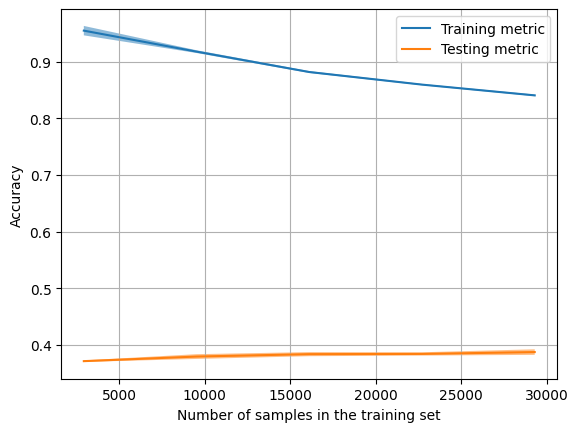

In [21]:
#Plot learning curves
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay
LearningCurveDisplay.from_estimator(model, Xtrain, Ytrain, cv = 5, score_type = "both", n_jobs = -1, score_name = "Accuracy")
plt.grid()
plt.show()


In [22]:
#from sklearn.metrics import roc_curve
#lr_probs = model.predict_proba(Xval)
#lr_probs = lr_probs[:, 1]
#print(Yval)
#lr_fpr, lr_tpr, _ = roc_curve(Yval, lr_probs)
#plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
#Did not implement a roc curve

In [23]:
#Test data pre-processing 
#Clean Test data 
test_set['Text'] = test_set['Text'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes
test_set['Text'] = [r.lower() for r in test_set['Text'] ]   #making everything lowercase
test_set['Text'] = [''.join([c for c in unicodedata.normalize('NFD', r) if not unicodedata.combining(c)]) for r in test_set['Text']] #removing accents
test_set['Text'] = test_set['Text'].apply(lambda r: re.sub(r'@\w+', '', r)) #remove mentions
test_set['Text'] = test_set['Text'].apply(lambda r: re.sub(r'([^α-ωΑ-Ω\s-])', ' ', r)) #only keeping greek letters, URLs are also removed this way
test_set['Text'] = test_set['Text'].apply(rem_stopwords) #remove stopwords
#Stemming
test_set['Text'] = test_set['Text'].apply(stemming)

In [24]:
#Test model
from sklearn.metrics import classification_report
df = pd.read_json(jsonpath2)
df['Sentiment_Num'] = df.Sentiment.map({
    'POSITIVE':0,
    'NEUTRAL':1,
    'NEGATIVE':2    
})

Ytrain = list(df['Sentiment_Num'])
vectorizer = TfidfVectorizer(ngram_range=(1, 2) , max_df=1.0, min_df=1, norm='l1')
Xtrain = vectorizer.fit_transform(df['Text'])

Xtest = vectorizer.transform(test_set['Text'])

model = LogisticRegression(penalty='l2', tol=0.01, C=8.4, random_state=420, solver='sag', max_iter=1000, multi_class='multinomial', n_jobs=-1)
model.fit(Xtrain, Ytrain)

predictions = model.predict(Xtest)
ids = test_set['New_ID']
list_of_tuples = list(zip(ids,predictions))
test_results = pd.DataFrame(list_of_tuples,columns=['Id','predicted'])
test_results['predicted'] = test_results.predicted.map({
    0:'POSITIVE',
    1:'NEUTRAL',
    2:'NEGATIVE'   
})

test_results.to_csv('submission.csv', index=False)

Sources: 
Stemming and lemmatisation readings:
https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/#h2_4
https://databasecamp.de/en/data/stemming-lemmatization


Stemmer: 
https://github.com/kpech21/Greek-Stemmer

Spacy POS tags list:
https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/

Cross-Validation:
https://scikit-learn.org/stable/modules/cross_validation.html

Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging

Scaling? 
https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features

Plots:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

f1_score:
https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec
